In [3]:
import sys
import requests
import json
import os
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import pandas as pd
import numpy as np
import sklearn
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
%matplotlib inline

**Get Access To Spotify Data Based on User Data**

In [161]:
cid = 'XXXXXXXXXXXXXXX'
secret = 'XXXXXXXXXXXXXXXXXX'
red='http://localhost:7777/callback'
username = 'XXXXXX'

In [463]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'playlist-read-private'
token = util.prompt_for_user_token(username, scope=scope, client_id=cid, client_secret=secret, redirect_uri=red)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

**Get user playlists**

In [464]:
results = sp.current_user_playlists(limit=50, offset=0)
results

{'href': 'https://api.spotify.com/v1/users/aditya8502/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': 'they could all be bad idk they haven&#x27;t marinated yet',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/5ZFtI5BysS2qnlCMI1vo9N'},
   'href': 'https://api.spotify.com/v1/playlists/5ZFtI5BysS2qnlCMI1vo9N',
   'id': '5ZFtI5BysS2qnlCMI1vo9N',
   'images': [{'height': 640,
     'url': 'https://mosaic.scdn.co/640/ab67616d0000b273ae12bcd137fb27b47958772dab67616d0000b273bf0774d9ada964aac3738f83ab67616d0000b273e072aae9ded009a030cb2726ab67616d0000b273ffd50036a95fc3fcce3038bc',
     'width': 640},
    {'height': 300,
     'url': 'https://mosaic.scdn.co/300/ab67616d0000b273ae12bcd137fb27b47958772dab67616d0000b273bf0774d9ada964aac3738f83ab67616d0000b273e072aae9ded009a030cb2726ab67616d0000b273ffd50036a95fc3fcce3038bc',
     'width': 300},
    {'height': 60,
     'url': 'https://mosaic.scdn.co/60/ab67616d0000b273ae12bcd137fb27b47958772dab676

**Get the track Id's for each playlist to find all the songs in the playlists**

In [7]:
playlists = []
for i in  range (len(results['items'])):
    playlists.append(results['items'][i]['id'])
playlists

['5ZFtI5BysS2qnlCMI1vo9N',
 '0N1rWjdHeGRsQyivjAKakn',
 '37i9dQZF1EJFQbW8N4a88f',
 '1t9ENlVf8wjw7EjdxWaawp',
 '2aHIjqtnEwVoVYTTzc9Aog',
 '6hQHPSJu27ZqtLgVkau2IA',
 '37i9dQZF1DXaK0O81Xtkis',
 '37i9dQZF1DXa19sXUAHiO1',
 '6oVZr50Q5LYeMoxFwUUEMr',
 '0qEtDtGylebKcku0iwPdb3',
 '2eC4OWSZXTclCzjCIVD2gX',
 '5D8Fl8JZ37JTRNqeDrrae6',
 '6J15dmtEHDkkNaeuEo2dQ4',
 '7eF9EnY5jkjhh4V39CoXHy',
 '7vHkWYYmMTVwHRcBWJBybT',
 '3SljI49trUf056gwFQpJlm',
 '33w1cXTBOWwUC19tfGVujm',
 '5y6TLNoIBy6XzIiknu7tMd',
 '3gPqdkn8SYxHJgezUku5Zw',
 '3UgMXMRXukRlvfOj678GNh',
 '4pLAZSOFPgJMTHOPhoDavi',
 '6HnP1GKwHBwthNw2VF6lEK',
 '3iKZSUDKBz2OsXTO913onH',
 '3W2l3OvHmCr75jNKkRspoh',
 '6VTDvM09YoUAFdUSjYvhcT',
 '07QNMfYLJLgbjq33OiSmD9',
 '4Q03UtJV9Nnq7ib9KylE9y',
 '68NTgOOQRAXqXTQgZPL3lH',
 '3a9gWstha3xtxdkzlgvzZl',
 '10pS1mFPAjpGpvoHaqDVyt',
 '3KOjGGBm1Ye3aFDBGkXK3T',
 '3j0cvc4IkhG3FDzkDUKCwE',
 '7cxjn9gcZ7F5k2zHPqTE2P',
 '77y1VRssaxQrnmD3ph1mVo',
 '0L9o47NHUyXQkW8dTk5Q2K',
 '7KSFTBBhDMokA5aRG84hRf',
 '63RjQQ5DEZ4TGldRzdTtyU',
 

**Create the user song database**

In [ ]:
def playlist_to_dataframe(playlist_id_list,liked):
    data = [] 
    current_track = []
    for item in playlist_id_list:
        songs= sp.playlist_items(item, fields=None, limit=100, offset=0, market=None, additional_types=('track', 'episode'))
        for i in range(0,len(songs['items'])):
            if(songs['items'][i]['track'] is not None):
                features = sp.audio_features(songs['items'][i]['track']['id'])
                if(features[0] is not None):
                    current_track =[songs['items'][i]['track']['id'],songs['items'][i]['track']['name'],songs['items'][i]['track']['artists'][0]['name']]
                    feature_list = [features[0]['acousticness'],features[0]['danceability'],features[0]['energy'],features[0]['instrumentalness'],features[0]['liveness'],features[0]['loudness'],features[0]['speechiness'],features[0]['tempo'],features[0]['time_signature'],liked]
                    current_track = current_track+feature_list
                    data.append(current_track)
    return data

user_tracks = pd.DataFrame(playlist_to_dataframe(playlists,1), columns = ['id', 'Track Name','Artist','Acousticness','Daceability','Energy','Instrumentalness','Liveness','Loudness','Speechiness','Tempo','Time Signature','Liked'])

In [9]:
user_tracks.head(10)

,id,Track Name,Artist,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Liked
0,0HqZX76SFLDz2aW8aiqi7G,Bones,Imagine Dragons,0.0206,0.773,0.742,0.000000,0.0754,-3.678,0.0460,114.071,4,1
1,3lz2JgAt4cyr04qDlBgTOv,Watch Me,Jaden,0.0108,0.734,0.722,0.000201,0.1570,-4.872,0.0710,129.927,4,1
2,2xhGZ3WzOa3tir28y7Cb88,Falling for U,Peachy!,0.7480,0.719,0.360,0.000002,0.0812,-12.034,0.3980,80.184,4,1
3,0P2CBPHJsD0BgdsqHedugp,frown,mxmtoon,0.1550,0.777,0.708,0.000221,0.0663,-5.220,0.0303,96.001,4,1
4,5QvbMioQZAEqN04tYUnCLv,sad disco,mxmtoon,0.0605,0.772,0.845,0.000000,0.3420,-4.546,0.0389,123.967,4,1
5,0XUU1fzICK7484jpGnfGvd,unspoken words,mxmtoon,0.5820,0.726,0.453,0.000008,0.2220,-7.129,0.0619,133.041,4,1
6,2z2S7tNx7Ckn87AUSvfyFe,no faker,mxmtoon,0.5310,0.726,0.695,0.000017,0.0414,-5.780,0.0309,97.031,4,1
7,36GBFPY75lJpxk7GugxhL7,ok on your own (feat. Carly Rae Jepsen),mxmtoon,0.4400,0.766,0.439,0.000014,0.0698,-8.842,0.0757,141.917,4,1
8,0R2T1MAVt8WbnNZi8Xj3Py,learn to love you,mxmtoon,0.1940,0.602,0.897,0.000312,0.1970,-3.745,0.0698,159.007,3,1
9,5WHgAhE3VlGpBiNKUWEyDY,fever dream,mxmtoon,0.1260,0.565,0.693,0.000037,0.0888,-5.962,0.0281,101.909,4,1


**Delete Duplicates**

In [149]:
user_tracks = user_tracks.drop_duplicates(subset=['Track Name', 'Artist'], keep='first')
user_tracks = user_tracks.reset_index(drop=True)

In [8]:
user_tracks = pd.read_csv("usertracks.csv")

**Convert Dataframe to csv file** 

In [63]:
user_tracks.to_csv('UserTracks.csv')

**Create a list of all spotify playlist ID's**

In [471]:
splay = sp.user_playlists('spotify')

slst = []
for i in range (len(splay['items'])):
    slst.append(splay['items'][i]['id'])

'Viva Latino'

**Create a database for all of spotify songs**

In [19]:
spotify_tracks = pd.DataFrame(playlist_to_dataframe(slst,0), columns = ['id', 'Track Name','Artist','Acousticness','Daceability','Energy','Instrumentalness','Liveness','Loudness','Speechiness','Tempo','Time Signature','Liked'])

**Create Final Database to hold both user and spotify datasets**

In [ ]:
frames = [user_tracks,spotify_tracks]
dt = pd.concat(frames)
dt = dt.drop_duplicates(subset=['Track Name', 'Artist'], keep='first')
dt = dt.reset_index(drop=True)

In [147]:
dt = pd.read_csv('dt.csv')

In [148]:
dt= dt.drop(columns= ['Unnamed: 0'])
dt

,id,Track Name,Artist,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Liked
0,0HqZX76SFLDz2aW8aiqi7G,Bones,Imagine Dragons,0.020600,0.773,0.742,0.000000,0.0754,-3.678,0.0460,114.071,4,1
1,5QvbMioQZAEqN04tYUnCLv,sad disco,mxmtoon,0.060500,0.772,0.845,0.000000,0.3420,-4.546,0.0389,123.967,4,1
2,0XUU1fzICK7484jpGnfGvd,unspoken words,mxmtoon,0.582000,0.726,0.453,0.000008,0.2220,-7.129,0.0619,133.041,4,1
3,36GBFPY75lJpxk7GugxhL7,ok on your own (feat. Carly Rae Jepsen),mxmtoon,0.440000,0.766,0.439,0.000014,0.0698,-8.842,0.0757,141.917,4,1
4,0R2T1MAVt8WbnNZi8Xj3Py,learn to love you,mxmtoon,0.194000,0.602,0.897,0.000312,0.1970,-3.745,0.0698,159.007,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4444,0GYTAipuswOBWFtk06kFCL,Redundant,Green Day,0.000009,0.482,0.946,0.001720,0.0891,-3.416,0.0353,115.883,4,0
4445,5nGCVIpxp0u4AYpVpK0pv4,When It's Time,Green Day,0.005920,0.399,0.605,0.000075,0.0927,-5.882,0.0253,149.465,4,0
4446,3CgT96psOXwPssPNvYPclP,99 Revolutions,Green Day,0.000410,0.475,0.949,0.000000,0.0646,-3.431,0.0859,172.035,4,0
4447,5JwuHzmJCmHuHGjP9W6KtK,Youngblood,Green Day,0.001040,0.522,0.963,0.000000,0.1490,-3.310,0.0528,136.515,4,0


Preparing Data For Model

In [150]:
dt_data = dt.drop(columns=['id','Track Name','Artist','Liked'])

In [151]:
dt.describe()

,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Liked
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,0.249056,0.628789,0.639248,0.052595,0.183317,-7.608611,0.104147,120.833249,3.955496,0.336480
std,0.286548,0.157584,0.213118,0.187872,0.143452,4.457029,0.112742,28.896695,0.322001,0.472558
min,0.000002,0.107000,0.006350,0.000000,0.009670,-33.900000,0.022400,45.306000,1.000000,0.000000
25%,0.021200,0.519000,0.520000,0.000000,0.095600,-8.654000,0.037200,98.007000,4.000000,0.000000
50%,0.121000,0.637000,0.661000,0.000005,0.124000,-6.606000,0.054300,119.966000,4.000000,0.000000
75%,0.410000,0.745000,0.801000,0.000712,0.232000,-5.077000,0.119000,139.091000,4.000000,1.000000
max,0.996000,0.981000,0.996000,0.975000,0.989000,1.085000,0.960000,208.418000,5.000000,1.000000


Graph each feature of the dataset

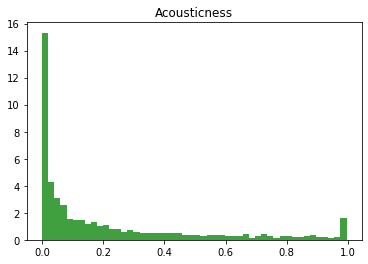

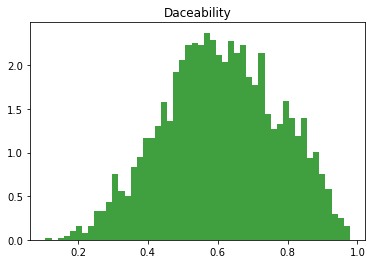

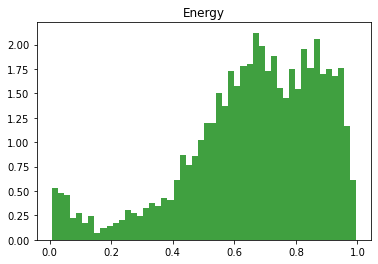

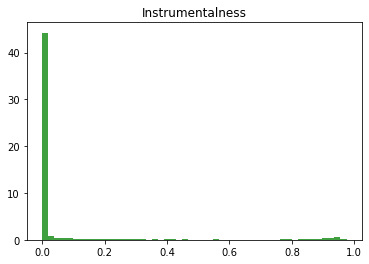

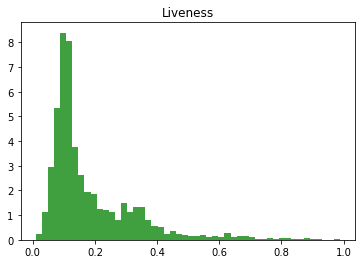

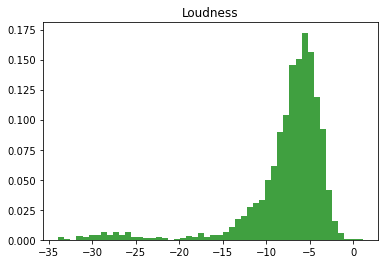

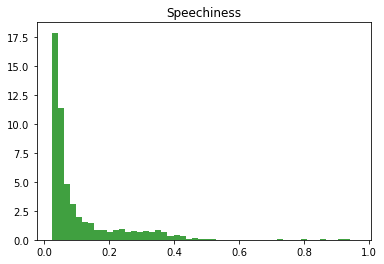

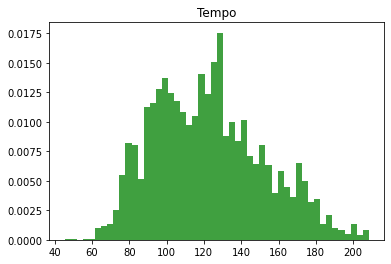

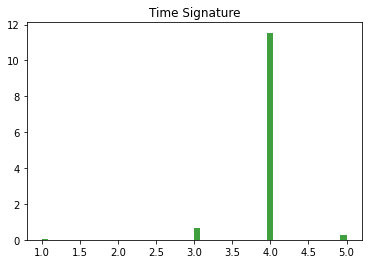

In [140]:
cols = list(song_data.columns)
for c in cols:
    plt.hist(song_data[c],50, density=True, facecolor='g', alpha=0.75,label = c)
    plt.title(c)
    plt.show()
    


###### Since the ranges for each feature is not consistent, it would help the model to normalize the data

Performing feature scaling so that all features carry the same weight during prediction 

In [152]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names = song_data.columns
dt[names] = scaler.fit_transform(dt[names])
unlistened = dt.loc[dt['Liked']==0]
user_tracks = dt.loc[dt['Liked']==1]
song_data = unlistened.drop(columns=['id','Track Name','Artist','Liked'])


In [153]:
dt.describe()

,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Liked
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,0.250055,0.597013,0.639517,0.053943,0.177312,0.751505,0.087187,0.463039,0.738874,0.336480
std,0.287699,0.180303,0.215347,0.192690,0.146480,0.127398,0.120245,0.177159,0.080500,0.472558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021283,0.471396,0.519022,0.000000,0.087744,0.721624,0.015785,0.323097,0.750000,0.000000
50%,0.121484,0.606407,0.661496,0.000005,0.116743,0.780163,0.034023,0.457722,0.750000,0.000000
75%,0.411645,0.729977,0.802961,0.000730,0.227023,0.823867,0.103029,0.574973,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
user_tracks.describe()

,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Liked
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.0
mean,0.317634,0.641815,0.595083,0.039867,0.171868,0.751727,0.076609,0.441892,0.740815,1.0
std,0.288131,0.156380,0.186360,0.163876,0.141671,0.094453,0.101448,0.167810,0.069308,0.0
min,0.000006,0.067506,0.000232,0.000000,0.010548,0.064142,0.000000,0.057954,0.000000,1.0
25%,0.065360,0.545767,0.481635,0.000000,0.087642,0.716107,0.015892,0.314036,0.750000,1.0
50%,0.221886,0.663616,0.606932,0.000003,0.114701,0.770616,0.032956,0.433855,0.750000,1.0
75%,0.523091,0.752860,0.727176,0.000344,0.206600,0.812634,0.090230,0.538336,0.750000,1.0
max,1.000000,1.000000,0.987875,0.973333,0.986726,0.936516,0.889078,0.984532,1.000000,1.0


Change the scaled features to be more specific rather than 

In [155]:
song_data.describe()

,Acousticness,Daceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature
count,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000
mean,0.215784,0.574293,0.662050,0.061081,0.180073,0.751392,0.092551,0.473763,0.737890
std,0.281392,0.187266,0.225352,0.205424,0.148807,0.141213,0.128416,0.180801,0.085613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000853,0.000000,0.000000
25%,0.011343,0.446224,0.543273,0.000000,0.087744,0.725168,0.015678,0.335106,0.750000
50%,0.078261,0.570938,0.690295,0.000007,0.117764,0.785894,0.034716,0.463078,0.750000
75%,0.315511,0.711670,0.838579,0.001121,0.234170,0.829991,0.110762,0.586799,0.750000
max,1.000000,0.996568,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [156]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(song_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [160]:
def getPlaylist(song_names):
    reval = pd.DataFrame()
    for song in song_names:
        metadata = user_tracks.loc[(user_tracks['Track Name'] == song) &(user_tracks['Artist'] == song_names[song])].drop(columns = ['id','Track Name','Artist','Liked'])
        metadata =tf.keras.utils.normalize(metadata, axis=1)
        distances , indices = knn.kneighbors(metadata,n_neighbors=21)
        indis = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1],reverse=True)[:0:-1]
        recommend_frame = []
        for index,distance in indis:
            recommend_frame.append({'Title':unlistened.iloc[index]['Track Name'],'Artist':unlistened.iloc[index]['Artist']})
        reccs = pd.DataFrame(recommend_frame)
        reval = reval.append(reccs)
    return reval.reset_index(drop=True)
songrecs = {'Woman':'Doja Cat'}

playlist = getPlaylist(songrecs)
playlist

,Title,Artist
0,Big Energy (feat. DJ Khaled) - Remix,Latto
1,Feelings,Mavado
2,Monalisa,Lojay
3,Peace Be Unto You (PBUY),Asake
4,Drag Me Out,Kah-Lo
5,Pantysito,Alejo
6,Know Your Worth (feat. Davido & Tems),Khalid
7,I Like You (A Happier Song) (with Doja Cat),Post Malone
8,ULTRA SOLO REMIX,Polimá Westcoast
9,broken people,almost monday
